In [1]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

C:\Users\ABHISEK\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [3]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [4]:
# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('ben-eng/ben.txt', encoding="utf-8"):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 4394


In [5]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [7]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 1884 unique input tokens.


In [8]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)
max_len_input

19

In [9]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [10]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 3568 unique output tokens.


In [11]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [12]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

In [15]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (4394, 19)
encoder_inputs[0]: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 28]
decoder_inputs[0]: [  2 168   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]
decoder_inputs.shape: (4394, 19)


In [16]:
import nltk
#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [17]:
import re
i=0
list_of_sent=[]
for sent in input_texts:
    filtered_sentence=[]
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [18]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,size=100, workers=4)

C:\Users\ABHISEK\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [19]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    try:
        if i < MAX_NUM_WORDS:
            embedding_vector = w2v_model.wv[re.sub(r'[?|!|\'|"|#]',r'',word)]
            if embedding_vector is not None:
                # words not found in embedding index will be all zeros.
                embedding_matrix[i] = embedding_vector
    except:
        pass

Filling pre-trained embeddings...


In [20]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

In [21]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

In [22]:
# assign the values
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [23]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)
# encoder_outputs, h = encoder(x) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

In [27]:
decoder_targets_one_hot.shape

(4394, 19, 3569)

In [29]:
decoder_targets.shape

(4394, 19)

In [30]:
#Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [31]:
decoder_inputs_x

<tf.Tensor 'embedding_2/embedding_lookup/Identity:0' shape=(?, 19, 256) dtype=float32>

In [32]:
num_words_output

3569

In [45]:
# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

In [46]:
# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [47]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

# Compile the model and train it
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=100,
  validation_split=0.2,
)

Train on 3515 samples, validate on 879 samples
Epoch 1/100
3515/3515 [==============================] - 62s 18ms/step - loss: 1.8196 - acc: 0.7768 - val_loss: 2.5894 - val_acc: 0.6548
Epoch 2/100
3515/3515 [==============================] - 58s 16ms/step - loss: 1.1894 - acc: 0.8200 - val_loss: 2.5634 - val_acc: 0.6709
Epoch 3/100
3515/3515 [==============================] - 58s 16ms/step - loss: 1.0568 - acc: 0.8290 - val_loss: 2.6102 - val_acc: 0.6716
Epoch 4/100
3515/3515 [==============================] - 57s 16ms/step - loss: 0.9622 - acc: 0.8388 - val_loss: 2.5879 - val_acc: 0.6696
Epoch 5/100
3515/3515 [==============================] - 83s 24ms/step - loss: 0.8849 - acc: 0.8480 - val_loss: 2.6094 - val_acc: 0.6722
Epoch 6/100
3515/3515 [==============================] - 69s 20ms/step - loss: 0.8173 - acc: 0.8557 - val_loss: 2.6122 - val_acc: 0.6737
Epoch 7/100
3515/3515 [==============================] - 67s 19ms/step - loss: 0.7542 - acc: 0.8626 - val_loss: 2.6385 - val_acc: 0

3515/3515 [==============================] - 57s 16ms/step - loss: 0.0467 - acc: 0.9763 - val_loss: 3.2416 - val_acc: 0.6880
Epoch 61/100
3515/3515 [==============================] - 57s 16ms/step - loss: 0.0462 - acc: 0.9760 - val_loss: 3.2265 - val_acc: 0.6881
Epoch 62/100
3515/3515 [==============================] - 58s 16ms/step - loss: 0.0458 - acc: 0.9764 - val_loss: 3.2331 - val_acc: 0.6867
Epoch 63/100
3515/3515 [==============================] - 58s 16ms/step - loss: 0.0457 - acc: 0.9762 - val_loss: 3.2632 - val_acc: 0.6874
Epoch 64/100
3515/3515 [==============================] - 57s 16ms/step - loss: 0.0448 - acc: 0.9761 - val_loss: 3.2635 - val_acc: 0.6874
Epoch 65/100
3515/3515 [==============================] - 57s 16ms/step - loss: 0.0446 - acc: 0.9760 - val_loss: 3.2798 - val_acc: 0.6870
Epoch 66/100
3515/3515 [==============================] - 57s 16ms/step - loss: 0.0447 - acc: 0.9758 - val_loss: 3.2830 - val_acc: 0.6882
Epoch 67/100
3515/3515 [=======================

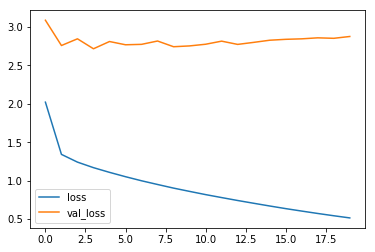

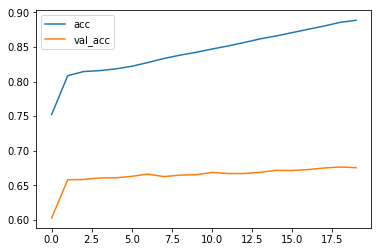

C:\Users\ABHISEK\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [36]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# Save model
model.save('e2b.h5')

In [53]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}


def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru
    
    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)


In [54]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: Make yourself at home.
Translation: এটা নিজের ঘর মনে করুন।
Continue? [Y/n]y
-
Input: Nice to see you again.
Translation: তোমাকে আবার দেখে ভালো লাগলো।
Continue? [Y/n]n


In [52]:
len(input_texts)

4394